In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

%load_ext autoreload
%autoreload 2

Thu Mar  4 12:03:36 PST 2021


In [2]:
data_path = '/ihme/homes/beatrixh/vivarium_research_lsff/data_prep/outputs/lsff_data_estimated.csv'

df = pd.read_csv(data_path)

In [3]:
df = df.drop(columns=['standard'])

In [4]:
# convert to numeric values.
# TODO: choose vals without random associations between close values
        # does it matter if the different vars are similar?
        # would it help to, say, choose veh from 10^vehicle?

In [5]:
nlocs = df.location_name.nunique()
loc_map = {i:j for (i,j) in zip(df.location_name.unique(),np.random.choice(nlocs, size = nlocs, replace = False))}

In [6]:
nvehs = df.vehicle.nunique()
veh_map = {i:j for (i,j) in zip(df.vehicle.unique(),np.random.choice(nvehs, size = nvehs, replace = False))}

In [7]:
nnutrs = df.nutrient.nunique()
nut_map = {i:j for (i,j) in zip(df.nutrient.unique(),np.random.choice(nnutrs, size = nnutrs, replace = False))}

In [8]:
df_numeric = df.copy()
df_numeric['location_name'] = df_numeric.location_name.map(loc_map)
df_numeric['vehicle'] = df_numeric.vehicle.map(veh_map)
df_numeric['nutrient'] = df_numeric.nutrient.map(nut_map)

In [9]:
df_numeric.head()

,location_name,vehicle,nutrient,percent of population eating vehicle,percent of population eating industrially produced vehicle,percent of population eating fortified vehicle
0,19,4,2,NaN,NaN,NaN
1,19,4,0,NaN,NaN,NaN
2,19,4,5,NaN,NaN,NaN
3,19,4,4,NaN,NaN,NaN
4,19,4,1,NaN,NaN,NaN


In [10]:
df_numeric.columns = [i.replace(" ","_") for i in df_numeric.columns]

In [11]:
for var in df_numeric.columns[-3:]:
    print(f'{df_numeric[var].isnull().sum()}/{len(df_numeric)} missing for {var}')

141/351 missing for percent_of_population_eating_vehicle
161/351 missing for percent_of_population_eating_industrially_produced_vehicle
132/351 missing for percent_of_population_eating_fortified_vehicle


In [12]:
## create a version with holdouts
df_partial = df_numeric.copy()
for _ in range(len(df_numeric)*3 // 4):
    j = np.random.choice(df_partial.columns[-3:])
    i = np.random.choice(df.index[df_partial[j].notnull()])
    df_partial.loc[i,j] = np.nan

In [13]:
for var in df_partial.columns[-3:]:
    print(f'{df_partial[var].isnull().sum()}/{len(df_partial)} missing for {var}')

219/351 missing for percent_of_population_eating_vehicle
255/351 missing for percent_of_population_eating_industrially_produced_vehicle
223/351 missing for percent_of_population_eating_fortified_vehicle


In [14]:
from statsmodels.imputation import mice

In [15]:
imp = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_partial)

In [16]:
%%time
N = 5
df_imputed = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp.update_all(n_iter=100)
    df_imputed[r] = imp.data

. . . . . CPU times: user 1min 6s, sys: 54.7 ms, total: 1min 6s
Wall time: 1min 6s


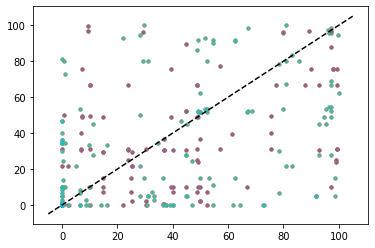

In [17]:
# let's see if we can improve with some covariates?
for col in df_partial.columns:
    for df_i in df_imputed.values():
        rows = df_partial[col].isnull() & df_numeric[col].notnull()
        plt.plot(df_numeric.loc[rows, col], df_i.loc[rows, col], '.', alpha=.5)

l,r,b,t = plt.axis()
lb = min(l,b)
ub = max(r,t)
plt.plot([lb, ub], [lb, ub], 'k--')

# what happens when we use all data?

In [18]:
imp_full = mice.MICEData(perturbation_method='boot', # or 'gaussian' although there seems to be something wrong with that option right now
                    data=df_numeric)

In [19]:
%%time
N = 5
df_imputed_full = {}
for r in range(N):
    if r % (N // 5) == 0:
        print('.', end=' ', flush=True)
    imp_full.update_all(n_iter=100)
    df_imputed_full[r] = imp.data

. . . . . CPU times: user 1min 4s, sys: 58.1 ms, total: 1min 4s
Wall time: 1min 4s


In [20]:
# checkout performance

In [21]:
# does imp remember prev iters? should df_imputed[i+1] be 'better' than df_imputed[i]?
# did they all do the same?

In [22]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_vehicle <
                  df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle)].shape[0])

90
90
90
90
90


In [23]:
for i in range(N):
    # more people eating fortifiable vehicle than people eating vehicle
    print(df_imputed_full[i][(df_imputed_full[i].percent_of_population_eating_industrially_produced_vehicle <
                  df_imputed_full[i].percent_of_population_eating_fortified_vehicle)].shape[0])

58
58
58
58
58
